# Introduction

For this tutorial we will utilize the SeasFire dataset. Please refer to [this link](https://github.com/SeasFire) for more information on this dataset



# Why xarray matters for Earth science data 

Earth science produces huge, structured, multi-dimensional data. That complexity means simple 2-D arrays or long CSVs quickly become fragile and hard to reason about.

Xarray is built exactly for that kind of data. It gives you labeled, N-dimensional arrays (DataArray) and collections of them (Dataset) with explicit dimension names (e.g. time, lat, lon, band) and coordinate variables (timestamps, geolocations, elevation). Those labels make code clearer, reduce indexing bugs, and let you express operations in the language of the science (e.g. “average over time”, “select this tile”, “group by month”).

Key benefits

- Self-documenting arrays: dimensions + coordinates + attributes → your data carries its metadata, so analyses are reproducible and easier to understand.

- Natural fit for remote sensing datacubes: time × y × x × channels (or other axes) map directly to xarray objects.

- Powerful indexing & selection: select by time range, lat/lon box, or named band without fragile integer indices.

- Easy aggregation & resampling: .groupby("time.month").mean() or .resample(time="1D").max() make temporal ops concise.

- Broadcasting with semantic alignment: xarray aligns arrays by coordinate labels rather than by raw shape — fewer mistakes.

- Integration with dask for scale: lazy arrays + chunking let you work with datasets that don't fit in memory (important for global RS).

- Interoperability with common formats: read and write NetCDF, Zarr, and use rioxarray to keep geospatial metadata (CRS, transforms).

- Cleaner pipelines for SSL: when you pretrain models on spatial-temporal data, xarray makes it easy to build consistent temporal stacks, handle missing timesteps, and create reproducible sampling logic for unlabeled vs labeled subsets.

# Demonstration of the SeasFire Cube

This dataset contains a number of variables representing wildfire drivers (meteorogology, vegetation, land cover, human activity, oceanic indices) and historical records of burned areas in a global scale temporally spaning from 2001 to 2021.

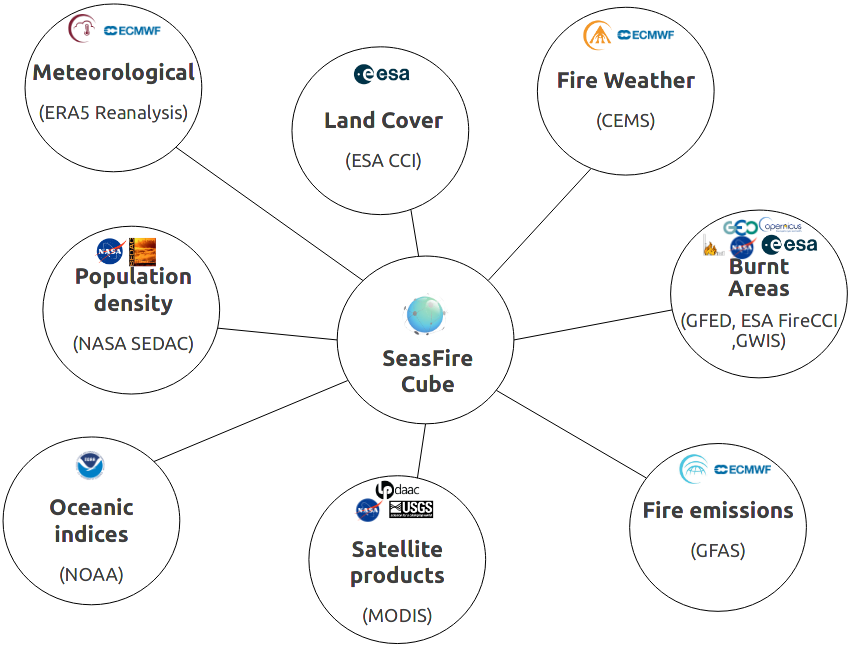



This datacube can be used for various wildfire-related applications, such as:

*   **Wildfire Susceptibility**: determine how prone different regions are to wildfires
*   **Burnt area forecasting**: predict the burned area of wildfires
*   **Wildfire emissions forecasting**: predict carbon emissions of a wildfire
*   **Analysis of spatiotemporal dynamics between fire drivers**: assess the relations between the various fire drivers and how much they affect the initialization and/or expansion of a wildfire
* **Monitoring of the evolution of wildfire regimes**: monitor the behaviour of wildfire systems and dynamics as they evolve through time and space.
* and many more!



In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
import folium
import geocoder

## Basic concepts

**Xarray** is an open-source Python module which allows us to manipulate and visualize multi-dimensional arrays. It supports the most popular data formats and it is interoperable with multiple scientific Python modules (e.g. numpy, pandas, dask, matplotlib) .

In this tutorial we are going to use the **xarray** library to open and explore a **zarr** dataset for global wildfire modeling, aka the SeasFire cube.

In [ ]:
ds = xr.open_zarr('/home/jovyan/data/seasfire_1deg.zarr')

In [ ]:
ds

Current memory usage: 0.28 GB


We see that there are **54 data variables** and **3 coordinates**:

*   latitude
*   longitude
*   time

Each spatiotemporal variable has 180 x 360 x 966 = 62,596,800 (lat x lon x time) datapoints.

Assuming 32-bit floats, this is 62,596,800 x 4 bytes ≃ 250 MB

Note, the original SeasFire cube is at 0.25 ° x 0.25 ° spatial resolution, aka 16x bigger at ≃4GB per variable.

Let's access a single variable

In [ ]:
ds.ndvi

Current memory usage: 0.28 GB


We see that the (966 x 180 x 360) array is split into 16 chunks of size (966, 45, 90)

**The chunk is the minimal dataset that is fetched from the disk**. Even if you access just one value, a chunk of size (966, 45, 90) will be fetched. 

*The* spatial resolution is 1 x 1 degree.

# Datacube manipulation

### Slicing

a) Selection by index


In [ ]:
ds.ndvi.isel(time=10, latitude=20, longitude=200).values

Current memory usage: 0.29 GB


/mnt/hdd1/diogenis/ellis_notebooks/.ellis/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


b) Selection by value

In [ ]:
ds.ndvi.sel(latitude=69.5, longitude=20.5, time=np.datetime64('2001-03-22')).values

Current memory usage: 0.29 GB


### Resampling

We can use the `.resample()` method to obtain data at different temporal resolutions.

For example, let's compute the average NDVI globally each year.

In [ ]:
ds.ndvi.resample(time="1YE").mean()

Current memory usage: 0.30 GB


We see that the `time` dimension now has size 21, i.e. the 21 years in our dataset.



### Aggregation

In [ ]:
ndvi_mean = ds.ndvi.mean()

Current memory usage: 0.30 GB


In [ ]:
ndvi_mean.values

Current memory usage: 0.30 GB


In [ ]:
ds.ndvi.mean(dim='time')

Current memory usage: 0.30 GB


In [ ]:
ds.ndvi.mean().values

Current memory usage: 0.30 GB


## Plotting

Xarray offers a nice wrapper method `.plot()` over the popular Matplotlib library, which allows us to directly create useful plots from our dataset.

we can also plot the temporal average of ndvi for all the timesteps.

Current memory usage: 0.31 GB


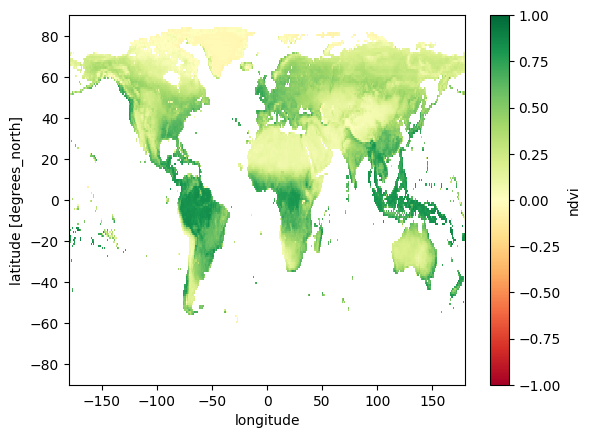

In [ ]:
ds.ndvi.mean(dim='time').plot(cmap="RdYlGn", vmax=1, vmin=-1)

Now let's plot the time-series of the average temperature for Rome versus Athens.

Current memory usage: 0.31 GB


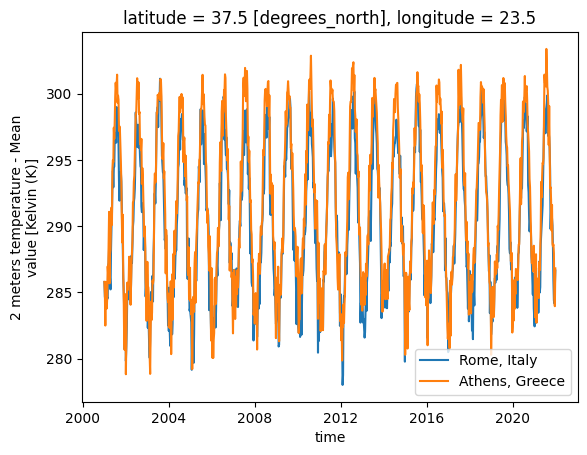

In [ ]:
place1 = 'Rome, Italy'
# g1 = geocoder.google(place1)
# lat1, lon1 = g1.latlng
lat1, lon1 =  (41.902782, 12.496366)

place2= 'Athens, Greece'
# g2 = geocoder.google(place2)
# lat2, lon2 = g2.latlng
lat2, lon2 = (37.9838, 23.7275)

var = 't2m_mean'

ds[var].sel(latitude=lat1, longitude=lon1, method='nearest').plot(label=place1)
ds[var].sel(latitude=lat2, longitude=lon2, method='nearest').plot(label=place2)
plt.legend()

Current memory usage: 0.32 GB


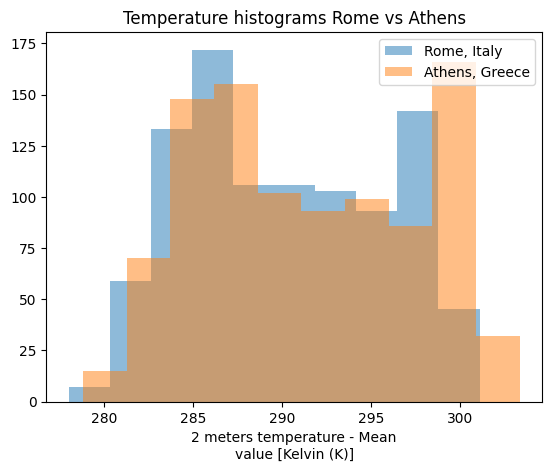

In [ ]:
ds[var].sel(latitude=lat1, longitude=lon1, method='nearest').plot.hist(label=place1, alpha=0.5)
ds[var].sel(latitude=lat2, longitude=lon2, method='nearest').plot.hist(label=place2, alpha=0.5)
plt.title('Temperature histograms Rome vs Athens')
plt.legend()

Now let's plot the wind speed for the whole earth as a series of 8-day periods.

Current memory usage: 0.34 GB


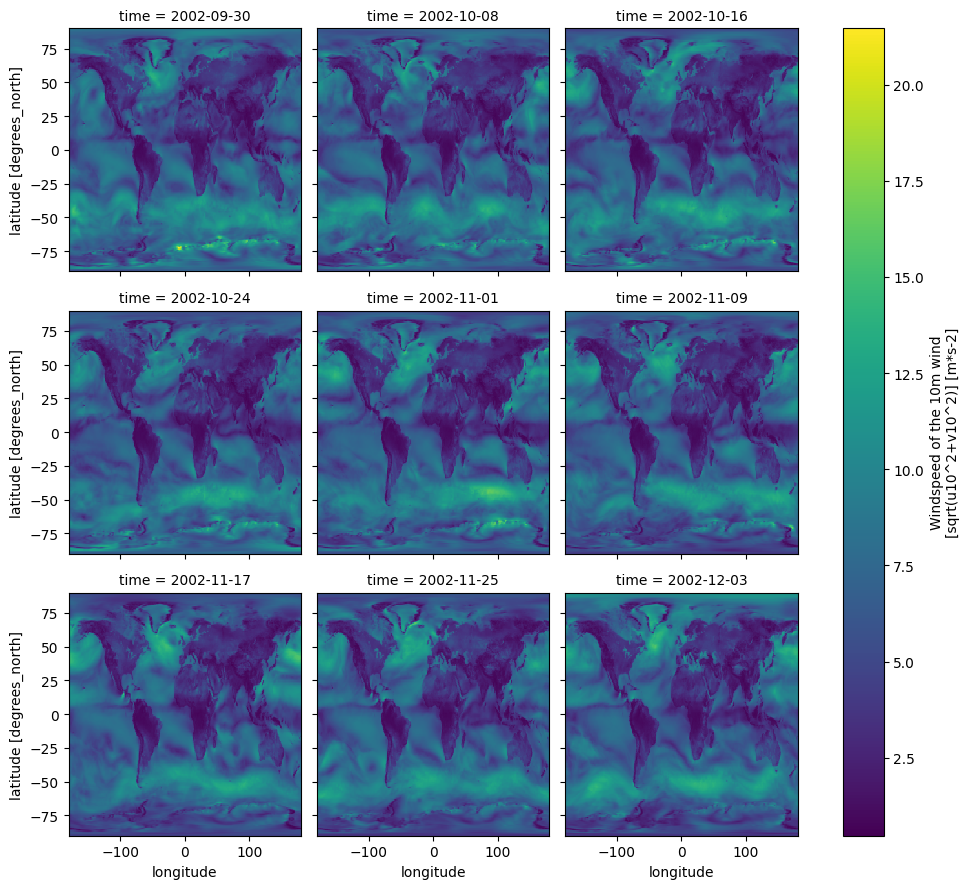

In [ ]:
ds.ws10.isel(time=slice(80, 89)).plot(
      col="time",
      col_wrap=3)

Finally, let's visualize the total burnt areas globally for a single year.

First, we must resample to get yearly data.

**Filtering**: Next we apply a sea mask so that oceans will be shown in white.

Current memory usage: 0.36 GB


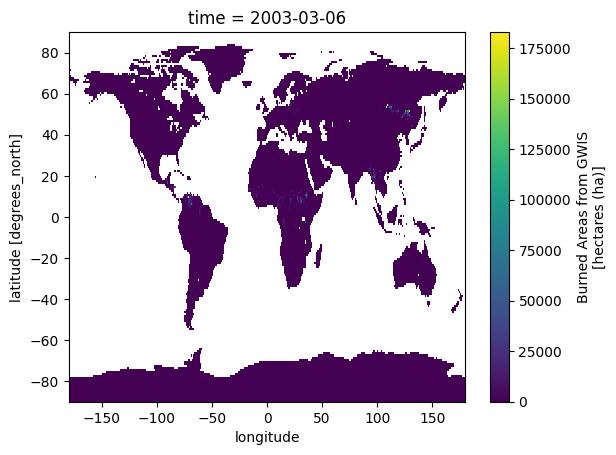

In [ ]:
ds.gwis_ba.isel(time=100).where(ds.lsm>0.5).plot()

Plot the temporal evolution of the average sea surface temperature (sst variable) for the whole earth.

Current memory usage: 0.37 GB


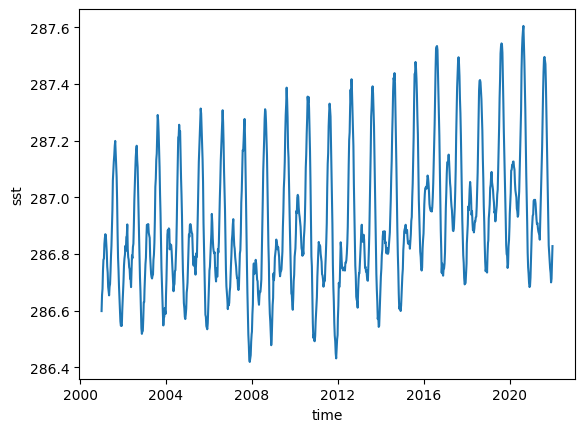

In [ ]:
ds['sst'].mean(dim=['latitude', 'longitude']).plot()

The same, but now the yearly average.


/mnt/hdd1/diogenis/ellis_notebooks/.ellis/lib/python3.10/site-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Current memory usage: 0.40 GB


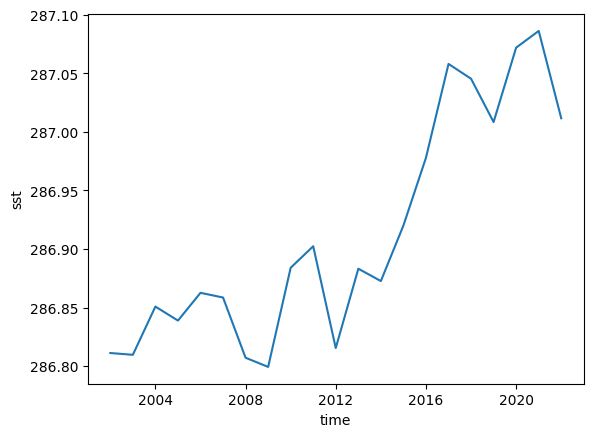

In [ ]:
ds['sst'].mean(dim=['latitude', 'longitude']).resample(time='1Y').mean().plot()

## Expanding the cube (Adding a new variable)

Let's try to add a new variable to our dataset.

> In order to do so, the new variable must:
> * have the same CRS (Coordinate Reference System)
> * have a subset of the dimensions (time, latitude, longitude)
> * be harmonized to the same spatiotemporal grid

To demonstrate the process of adding a mew variable, we will open a second dataset which contains biomes for the whole Earth (`biomes.nc`) [1]. You can add a shortcut to it in your Google Drive and load it as we saw previously.

[1] Eric Dinerstein and others, An Ecoregion-Based Approach to Protecting Half the Terrestrial Realm, BioScience, Volume 67, Issue 6, June 2017, Pages 534–545, https://doi.org/10.1093/biosci/bix014

Note that this is a NetCDF file, not a Zarr. However xarray can handle it just as fine.

In [ ]:
biomes_ds = xr.open_dataset('/home/jovyan/data/biomes.nc')
biomes_ds

Current memory usage: 0.41 GB


This dataset is of size (720, 1440) and not (180, 360) as the cube.

Current memory usage: 0.42 GB


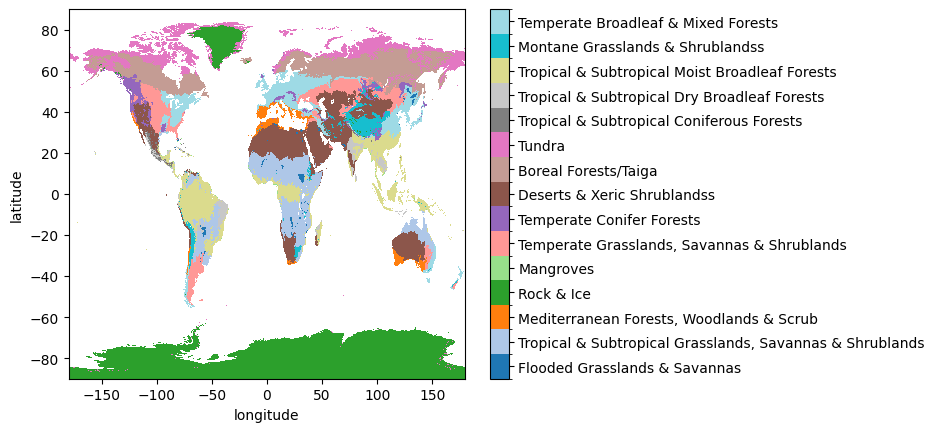

In [ ]:
dict_biomes = dict(
    [
        (1, "Flooded Grasslands & Savannas"),
        (2, "Tropical & Subtropical Grasslands, Savannas & Shrublands"),
        (3, "Mediterranean Forests, Woodlands & Scrub"),
        (4, "Rock & Ice"),
        (5, "Mangroves"),
        (6, "Temperate Grasslands, Savannas & Shrublands"),
        (7, "Temperate Conifer Forests"),
        (8, "Deserts & Xeric Shrublandss"),
        (9, "Boreal Forests/Taiga"),
        (10, "Tundra"),
        (11, "Tropical & Subtropical Coniferous Forests"),
        (12, "Tropical & Subtropical Dry Broadleaf Forests"),
        (13, "Tropical & Subtropical Moist Broadleaf Forests"),
        (14, "Montane Grasslands & Shrublandss"),
        (15, "Temperate Broadleaf & Mixed Forests"),
    ]
)

im = biomes_ds.biomes.plot(
    cmap="tab20",
    levels=np.array([0] + list(dict_biomes.keys())) + 0.5,
    add_colorbar=False)

cb = plt.colorbar(im, ticks=list(dict_biomes.keys()), spacing="proportional")
cb.set_ticklabels(list(dict_biomes.values()))

From the above summary we see that there is no `time` coordinate, and also the spatial resolution of the `latitude` and `longitude` coordinates is not 1x1 as in our initial dataset.

The absence of a `time` coordinate poses no issue because biomes already contains a subset of the coordinates (`latitude`, `longitude`).

To align `biomes` with `ds` we can use the `.interp_like()` method to interpolate the data in `biomes` like the data in `ds`.


In [ ]:
biomes_1deg_ds = biomes_ds.interp_like(ds, method='nearest')

Current memory usage: 0.45 GB


In [ ]:
biomes_1deg_ds

Current memory usage: 0.45 GB


Current memory usage: 0.45 GB


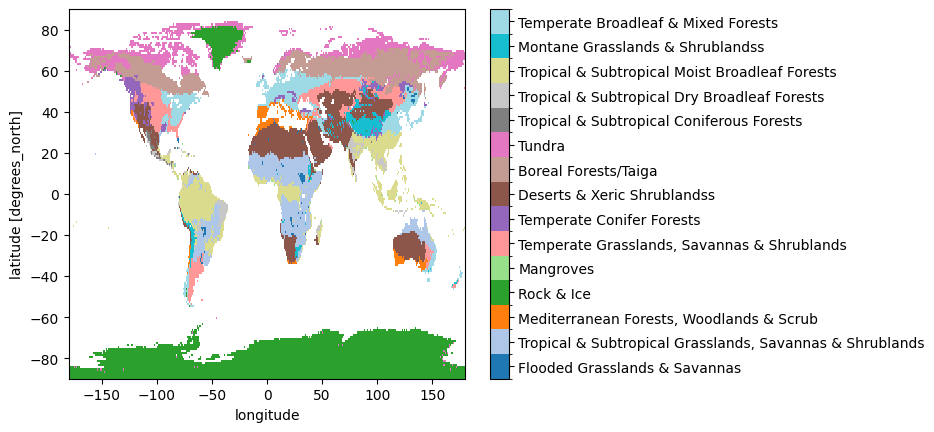

In [ ]:
im = biomes_1deg_ds.biomes.plot(
    cmap="tab20",
    levels=np.array([0] + list(dict_biomes.keys())) + 0.5,
    add_colorbar=False)

cb = plt.colorbar(im, ticks=list(dict_biomes.keys()), spacing="proportional")
cb.set_ticklabels(list(dict_biomes.values()))

Now let's add our new aligned variable to our dataset.

In [ ]:
ds['biomes'] = biomes_1deg_ds.biomes
ds

Current memory usage: 0.45 GB


# Exercises in the California Wildfires

In [ ]:
# define a bounding box for California
xmin , ymin , xmax , ymax = -124.409591 , 32.534156 , -114.131211 , 42.009518

Current memory usage: 0.45 GB


In [ ]:
map = folium.Map(location=[(ymin + ymax) / 2, (xmin + xmax)/2], zoom_start=6, control_scale=True)
folium.Marker(location=[ymin, xmin], popup='California (bottom left)').add_to(map)
folium.Marker(location=[ymax, xmax], popup='California (top right)').add_to(map)
map

Current memory usage: 0.45 GB


Question 0: Select the cube containing California for years 2001 to 2020 included.

<details>
<summary>Answer</summary>

We do this with the `.sel()` method.

Note the tricky part is that the latitude and longitude coordinates are in descending order. So we need to select the coordinates in reverse order.

```python
california = ds.sel(latitude=slice(ymax, ymin), longitude=slice(xmin, xmax), time=slice('2001-01-01', '2020-12-31'))
```
</details>

In [ ]:
# TODO FILL CODE 

Current memory usage: 0.45 GB


Now let's plot the sum of burned areas in California for each year.

<details>
<summary>Answer</summary>

```python
california.resample(time='1Y').sum().sum(dim=('longitude', 'latitude'))['gwis_ba'].plot()
```
</details>

In [ ]:
# TODO FILL CODE

We see a large peak in 2020, which the year of the [extreme California wildfires](https://en.wikipedia.org/wiki/2020_California_wildfires).

You will now help to explore this further.

### Exercises

Exercise 1: Which is the month with the most burned area in the 2020 wilfires in California?

<details>
<summary>Answer</summary>
The answer is August.

There are many ways to do this.

One way is to plot the sum of the burned area for the year, resampling at a monthly scale and then finding visually the maximum value, as shown below.


Try this code sample:
```
california.gwis_ba.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='1M').sum().sum(dim=('longitude', 'latitude')).plot()
```
</details>

In [ ]:
# TODO FILL CODE

Exercise 2: Does it coincide with the hottest month in terms of average temperature (t2m_mean)?

<details>
<summary>Answer</summary>
The answer is yes. However it is a bit more tricky.

Initialy we think it can be done with the same code as above, but replacing the burned area `gwis_ba` with the temperature variable `t2m_mean`.


Code sample:
```
california.t2m_mean.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='1M').sum().sum(dim=('longitude', 'latitude')).plot()
```

The problem is that it is now not so evident by looking at the plot.

We can use the `.argmax()` method to find the index of the maximum value.

Code sample:
```
california.t2m_mean.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='1M').sum().sum(dim=('longitude', 'latitude')).argmax()
```
</details>

In [ ]:
# TODO FILL CODE

Exercise 3: Plot a map burned area for the hottest month?

<details>
<summary>Answer</summary>

This can be done with the code below. We know already that the hottest month was August. So we can select the data for August and then plot it.

Try this code sample:
```
california.gwis_ba.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='1M').sum()[7].plot()
```
</details>

In [ ]:
# TODO FILL CODE